In [1]:
import os
import json
import pandas as pd

ratings_dir = "../data/ratings/deepseek_ratings"  # klasör yolu
all_data = []

for filename in os.listdir(ratings_dir):
    if filename.endswith(".json"):
        level = filename.split("_")[1].split(".")[0]  # örn: ratings_A1.json → A1
        with open(os.path.join(ratings_dir, filename), "r", encoding="utf-8") as f:
            data = json.load(f)
            all_data.extend(data)

df = pd.DataFrame(all_data)

# Ratings sözlüğünü ayrı sütunlara aç
ratings_df = df["ratings"].apply(pd.Series)
df = pd.concat([df.drop(columns=["ratings"]), ratings_df], axis=1)

print(df.head())


     task_id                                              model level    word  \
0  C1_backup                                    Claude Sonnet 4    C1  backup   
1  C1_backup             Ministral-8B-Instruct-2410.Q4_K_M.gguf    C1  backup   
2  C1_backup                                        GPT-4-turbo    C1  backup   
3  C1_backup  Llama-3.2-8B-Instruct/Llama-3.2-8B-Instruct-Q4...    C1  backup   
4  C1_backup                                   Gemini 2.5 Flash    C1  backup   

        label                                           sentence  word_usage  \
0  Sentence A  The IT department implemented a comprehensive ...         5.0   
1  Sentence B  It's important to have a backup plan in case o...         5.0   
2  Sentence C  It’s essential to create a backup of your file...         5.0   
3  Sentence D  The company has a backup plan in case of a nat...         5.0   
4  Sentence E  It's crucial to create a backup of all your im...         5.0   

   clarity  grammar  naturalness

In [2]:
model_level_avg = df.groupby(["model", "level"])[["word_usage", "clarity", "grammar", "naturalness"]].mean().reset_index()
print(model_level_avg)


                                                model level  word_usage  \
0                                     Claude Sonnet 4    A1        4.90   
1                                     Claude Sonnet 4    A2        5.00   
2                                     Claude Sonnet 4    B1        5.00   
3                                     Claude Sonnet 4    B2        5.00   
4                                     Claude Sonnet 4    C1        5.00   
5                                         GPT-4-turbo    A1        5.00   
6                                         GPT-4-turbo    A2        5.00   
7                                         GPT-4-turbo    B1        5.00   
8                                         GPT-4-turbo    B2        5.00   
9                                         GPT-4-turbo    C1        5.00   
10                                   Gemini 2.5 Flash    A1        4.90   
11                                   Gemini 2.5 Flash    A2        5.00   
12                       

In [3]:
df["overall"] = df[["word_usage", "clarity", "grammar", "naturalness"]].mean(axis=1)
overall_avg = df.groupby("model")["overall"].mean().sort_values(ascending=False)
print(overall_avg)


model
GPT-4-turbo                                                5.000
Claude Sonnet 4                                            4.980
Gemini 2.5 Flash                                           4.980
Llama-3.2-8B-Instruct/Llama-3.2-8B-Instruct-Q4_K_M.gguf    4.880
Llama-3.2-3B-Instruct-Q4_K_M.gguf                          4.855
Ministral-8B-Instruct-2410.Q4_K_M.gguf                     4.730
Name: overall, dtype: float64


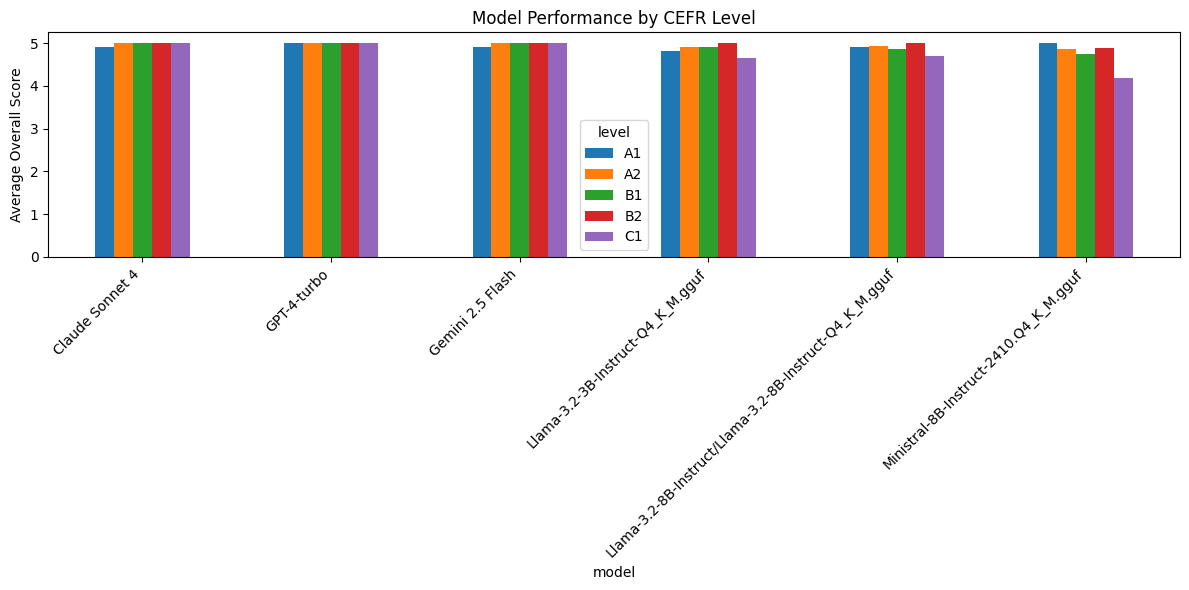

In [6]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt

# 1) Tüm dosyaları topla
ratings_dir = "../data/ratings/deepseek_ratings"
rows = []
for fn in os.listdir(ratings_dir):
    if fn.endswith(".json"):
        with open(os.path.join(ratings_dir, fn), "r", encoding="utf-8") as f:
            rows.extend(json.load(f))

df = pd.DataFrame(rows)

# 2) ratings kolonunu aç ve overall ekle
rat = df["ratings"].apply(pd.Series)
df = pd.concat([df.drop(columns=["ratings"]), rat], axis=1)

# isimler: word_usage, clarity, grammar, naturalness
df["overall"] = df[["word_usage", "clarity", "grammar", "naturalness"]].mean(axis=1)

# 3) Model×Seviye ortalamaları
model_level_avg = (
    df.groupby(["model", "level"], as_index=False)[
        ["word_usage", "clarity", "grammar", "naturalness", "overall"]
    ].mean()
)

# 4) Overall grafiği
pivot = model_level_avg.pivot(index="model", columns="level", values="overall")
pivot.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Average Overall Score")
plt.title("Model Performance by CEFR Level")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [8]:
import os, json
import pandas as pd

# --- 1) Verileri yükle ---
ratings_dir = "../data/ratings/deepseek_ratings"
rows = []
for fn in os.listdir(ratings_dir):
    if fn.endswith(".json"):
        with open(os.path.join(ratings_dir, fn), "r", encoding="utf-8") as f:
            rows.extend(json.load(f))

df = pd.DataFrame(rows)

# --- 2) ratings dict'ini aç ---
rat = df["ratings"].apply(pd.Series)
df = pd.concat([df.drop(columns=["ratings"]), rat], axis=1)

# overall ekle
df["overall"] = df[["word_usage", "clarity", "grammar", "naturalness"]].mean(axis=1)

# --- 3) Model × Seviye ortalamaları ---
model_level_avg = (
    df.groupby(["model", "level"], as_index=False)[
        ["word_usage", "clarity", "grammar", "naturalness", "overall"]
    ].mean()
)

# --- 4) Her kriter için genel sıralama (tüm seviyeler birleşik) ---
criteria_ranking = (
    df.groupby("model")[["word_usage", "clarity", "grammar", "naturalness", "overall"]]
    .mean()
    .sort_values("overall", ascending=False)
    .reset_index()
)

# --- 5) Genel sıralama sadece overall üzerinden ---
overall_ranking = (
    df.groupby("model")["overall"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# --- 6) CSV olarak kaydet ---
out_dir = "../data/analysis_results"
os.makedirs(out_dir, exist_ok=True)

model_level_avg.to_csv(os.path.join(out_dir, "model_level_avg.csv"), index=False)
criteria_ranking.to_csv(os.path.join(out_dir, "criteria_ranking.csv"), index=False)
overall_ranking.to_csv(os.path.join(out_dir, "overall_ranking.csv"), index=False)

print("✅ Analiz CSV dosyaları kaydedildi:")
print(f"- {os.path.join(out_dir, 'model_level_avg.csv')}")
print(f"- {os.path.join(out_dir, 'criteria_ranking.csv')}")
print(f"- {os.path.join(out_dir, 'overall_ranking.csv')}")


✅ Analiz CSV dosyaları kaydedildi:
- ../data/analysis_results/model_level_avg.csv
- ../data/analysis_results/criteria_ranking.csv
- ../data/analysis_results/overall_ranking.csv
